In [72]:
import json
import os
import glob
import csv
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns 
import numpy as np
from scipy.stats import zscore
import gzip
from sklearn.preprocessing import MultiLabelBinarizer

In [73]:
data_dir = '/shared/2/projects/framing/data/'
tweet_base_path = os.path.join(data_dir,'immigration_tweets_by_country_07-16/')
tweet_ideology_file = os.path.join(data_dir,'tweet-ideology-07-16.json')
lexical_frame_file = '/shared/2/projects/framing/intermediate_results/frame_labels/lexical_frames_08-04.json'

In [3]:
def collect_tweets(tweet_base_path,start_year,end_year,countries):
    tweets = []
    for year in range(start_year,end_year+1):
        for country in countries:
            filename = os.path.join(tweet_base_path,str(year),country + '.gz')
            with gzip.open(filename,'r') as f:
                for i,line in enumerate(f):
                    tweet_obj = json.loads(line.decode('utf-8').strip())
                    tweet_id = tweet_obj['id_str']
                    num_replies = tweet_obj['reply_count']
                    num_retweets = tweet_obj['retweet_count']
                    num_likes = tweet_obj['favorite_count']
                    num_followers = tweet_obj['user']['followers_count']
                    num_followed = tweet_obj['user']['friends_count']
                    tweet_info = [tweet_id,year,country,num_replies,num_retweets,num_likes,num_followers,num_followed]
                    tweets.append(tweet_info)
    colnames = ['id','year','country','num_replies','num_retweets','num_likes','num_followers','num_followed']
    return pd.DataFrame(tweets,columns=colnames)

In [6]:
df = collect_tweets(tweet_base_path,2018,2019,['EU','GB','US'])

In [7]:
df.to_csv(os.path.join(data_dir,'tweet_metadata_07-21.csv'))

In [3]:
df = pd.read_csv(os.path.join(data_dir,'tweet_metadata_07-21.csv'))

In [5]:
with open(lexical_frame_file,'r') as f:
     lex_frames = json.load(f)

In [6]:
with open(tweet_ideology_file,'r') as f:
    ideology = json.load(f)

In [7]:
scores = []
lex = []
for id_str in df['id']:
    lex.append(lex_frames[str(id_str)])
    if str(id_str) in ideology:
        scores.append(float(ideology[str(id_str)]))
    else:
        scores.append(None)

In [8]:
df['lex'] = lex
df['ideology'] = scores

/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [10]:
df_country = df.explode('lex')[['id','year','country','lex']]
df_ideology = df.explode('lex')[['ideology','lex','country']]

In [11]:
df_country

,id,year,country,lex
0,1055475460392415233,2018,EU,immigrant
1,1003792256267116545,2018,EU,immigrant
2,1036332221580410880,2018,EU,migration
3,1071531426837876736,2018,EU,immigration
4,1077151711138144256,2018,EU,immigration
...,...,...,...,...
2661432,1144492585173438465,2019,US,immigration
2661433,1159807160978759683,2019,US,immigrants
2661433,1159807160978759683,2019,US,illegal immigrants
2661434,1146065610633179136,2019,US,immigrants


In [67]:
df_country['lex'] = df_country['lex'].replace('immigrants','immigrant')
df_country['lex'] = df_country['lex'].replace('migrants','migrant')
df_country['lex'] = df_country['lex'].replace('emigrants','emigrant')
df_country['lex'] = df_country['lex'].replace('illegal aliens','illegal alien')
df_country['lex'] = df_country['lex'].replace('illegal immigrants','illegal immigrant')
df_ideology = df_ideology[df_ideology['country']=='US']
df_ideology = df_ideology.dropna()
df_ideology['ideology-zscore'] = zscore(df_ideology['ideology'])
df_ideology['lex'] = df_ideology['lex'].replace('immigrants','immigrant')
df_ideology['lex'] = df_ideology['lex'].replace('migrants','migrant')
df_ideology['lex'] = df_ideology['lex'].replace('emigrants','emigrant')
df_ideology['lex'] = df_ideology['lex'].replace('illegal aliens','illegal alien')
df_ideology['lex'] = df_ideology['lex'].replace('illegal immigrants','illegal immigrant')

In [68]:
lex_frames = pd.get_dummies(df_country['lex']).columns
df_lex_country = pd.concat([df_country,pd.get_dummies(df_country['lex'])],axis=1)
df_lex_ideology = pd.concat([df_ideology,pd.get_dummies(df_ideology['lex'])],axis=1)

In [80]:
def plot_frame_by_country(df,country,frame_list):
    p_frame_country = df[df['country']==country][frame_list].mean(axis=0).sort_index()
    p_frame = df[frame_list].mean(axis=0).sort_index()
    df_prob = pd.DataFrame()
    norm_prob = f'P(Frame|{country}) / P(Frame)'
    df_prob[norm_prob] = p_frame_country / p_frame
    df_prob = df_prob.reset_index().sort_values(norm_prob,ascending=False)
    df_prob.columns = ['Frame',norm_prob]
    sns.barplot(x=norm_prob,y='Frame',data=df_prob)
    plt.savefig(f'/home/juliame/framing/plots/lexical_{country}_09-17.pdf',bbox_inches='tight')

In [81]:
def plot_frame_by_ideology(df,frame_list,norm=False):
    df1 = pd.DataFrame()
    for frame in frame_list:
        ideology_col = 'ideology'
        if norm:
            ideology_col = 'ideology-zscore'
        df1[frame] = df.apply(lambda x: x[ideology_col] if x[frame] == 1 else None, axis=1)
    df1 = pd.melt(df1)
    df1.columns = ['Frame','Ideology']
    order = df1.groupby('Frame').agg('mean').reset_index().sort_values('Ideology')['Frame']
    sns.pointplot(x='Ideology',y='Frame',data=df1,join=False,palette='husl',order=order)
    plt.savefig(f'/home/juliame/framing/plots/lexical_ideology_09-17.pdf',bbox_inches='tight')
    

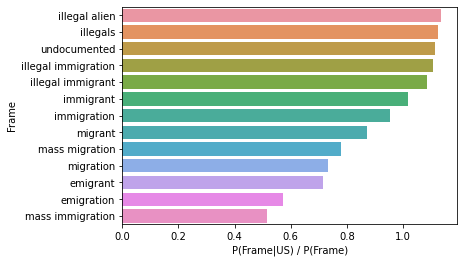

In [82]:
plot_frame_by_country(df_lex_country,'US',lex_frames)

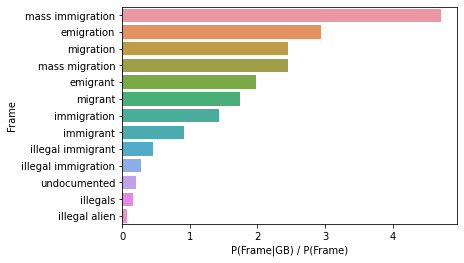

In [83]:
plot_frame_by_country(df_lex_country,'GB',lex_frames)

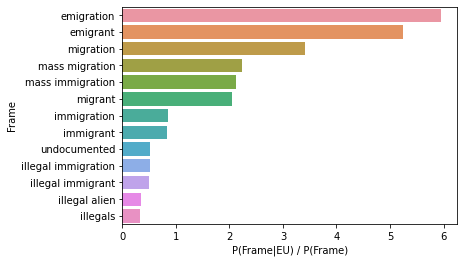

In [84]:
plot_frame_by_country(df_lex_country,'EU',lex_frames)

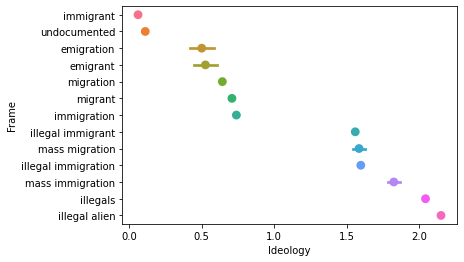

In [85]:
plot_frame_by_ideology(df_lex_ideology,lex_frames)


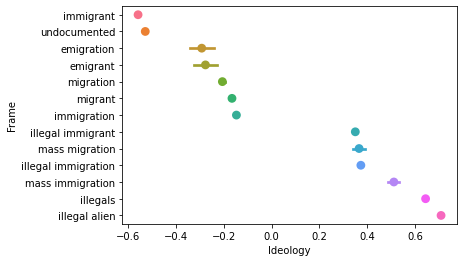

In [70]:
plot_frame_by_ideology(df_lex_ideology,lex_frames,norm=True)

In [71]:
df

,Unnamed: 0,id,year,country,num_replies,num_retweets,num_likes,num_followers,num_followed,lex,ideology
0,0,1055475460392415233,2018,EU,0,0,0,23468,7583,[immigrant],NaN
1,1,1003792256267116545,2018,EU,0,0,0,30950,31055,[immigrant],NaN
2,2,1036332221580410880,2018,EU,0,0,0,1182,1084,[migration],NaN
3,3,1071531426837876736,2018,EU,0,0,0,23,56,[immigration],NaN
4,4,1077151711138144256,2018,EU,0,0,0,32,55,"[immigration, mass immigration]",NaN
...,...,...,...,...,...,...,...,...,...,...,...
2661431,2661431,1148706053347041282,2019,US,0,0,0,85,201,[migrants],NaN
2661432,2661432,1144492585173438465,2019,US,0,0,0,1111,3862,[immigration],-0.931966
2661433,2661433,1159807160978759683,2019,US,0,0,0,192,263,"[immigrants, illegal immigrants]",NaN
2661434,2661434,1146065610633179136,2019,US,0,0,0,49,78,[immigrants],NaN
